In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [16]:
# TODO: object oriented

# K-armed stochastic bandit envirnment
class Environment:
    def __init__(self, k):
        self.k = k
        self.bandits = []
        for i in range(k):
            a = np.random.uniform(0, 1) 
            b = np.random.uniform(0, 1)
            self.bandits.append((a,b))
            
    def get_reward(self, arm):  # TODO: add diversity to distributions, and show prior evolutions...
        a, b = self.bandits[arm]
        return np.random.uniform(a,b)

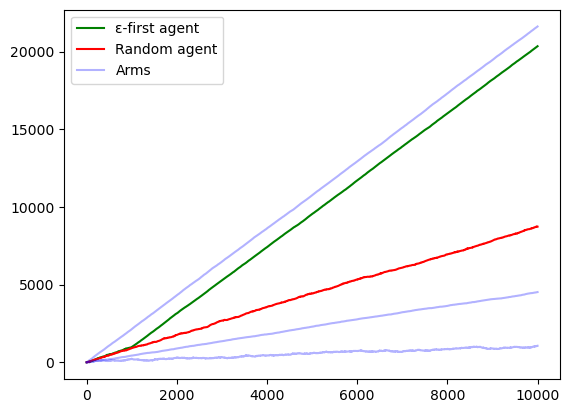

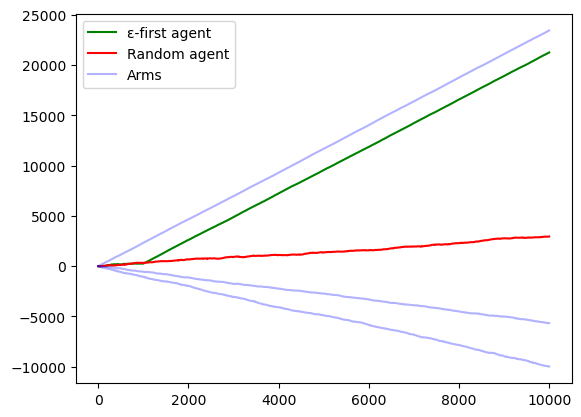

In [148]:
k = 3
N = 10000
epsilon = 0.1

bandits = []
for i in range(k):
    a = np.random.uniform(-1, 3)
    b = np.random.uniform(0.5, 3)
    bandits.append((a,b))

def get_reward(arm):
        a, b = bandits[arm]
        return np.random.normal(a,b)

arm1_scores = []
arm2_scores = []
arm3_scores = []

for i in range(N):
    if len(arm1_scores) == 0:
        arm1_scores.append(get_reward(0))
        arm2_scores.append(get_reward(1))
        arm3_scores.append(get_reward(2))
    else:
        arm1_scores.append(get_reward(0) + arm1_scores[-1])
        arm2_scores.append(get_reward(1) + arm2_scores[-1])
        arm3_scores.append(get_reward(2) + arm3_scores[-1])

random_arm = []

for i in range(N):
    arm = np.random.randint(0, k)
    reward = get_reward(arm)
    if len(random_arm) == 0:
        random_arm.append(reward)
    else:
        random_arm.append(reward + random_arm[-1])

epsilon_first = []
arm_history = {}

for arm_index, _ in enumerate(bandits):
    arm_history[arm_index] = []
    
for i in range(N):
    if i < (epsilon * N):
        arm = np.random.randint(0, k)
        reward = get_reward(arm)
        arm_history[arm].append(reward)
    else:
        curr_best_EV = 0
        curr_best_arm = 0
        for arm in range(k):
            EV = np.mean(arm_history[arm])
            if EV > curr_best_EV:
                curr_best_EV = EV
                curr_best_arm = arm
        reward = get_reward(curr_best_arm)
    if len(epsilon_first) == 0:
        epsilon_first.append(reward)
    else:
        epsilon_first.append(reward + epsilon_first[-1])

plt.plot(epsilon_first, c="g", label="ε-first agent")
plt.plot(random_arm, c="r", label="Random agent")
plt.plot(arm1_scores, c="b", alpha=0.3, label="Arms", )
plt.plot(arm2_scores, c="b", alpha=0.3)
plt.plot(arm3_scores, c="b", alpha=0.3)
plt.legend()
plt.show()